In [1]:
import numpy as np
from numpy import linalg

import matplotlib.pyplot as plt
from scipy import optimize
from scipy import integrate

In [2]:
# Run cell to increase font sizes. Usefull when saving plots
SMALL_SIZE = 20
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["figure.figsize"] = (12,9)

In [3]:
class lac_operon_system:

    def __init__(self, L, Vmax=1, n=5, Km=2, k1=0.05, k2=1, k3=1, k4=1, k5=0.2):

        self.L = L
        self.Vmax = Vmax
        self.n = n
        self.Km = Km
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        self.k4 = k4
        self.k5 = k5

    def dMdt(self, A, M):
        return self.k1 + self.k2 * (1 - (1/(1 + A**self.n))) - self.k3 * M

    def dAdt(self, A, M):
        return self.k4 * M * self.L - self.k5 * A - self.Vmax * M * A / (self.Km + A)

    def nullcline_M(self, A):
        return (self.k1 + self.k2 * (1 - 1/(1 + A**self.n))) / self.k3

    def nullcline_A(self, A):
        return self.k5 * A / (self.k4 * self.L - (self.Vmax * A) / (self.Km + A))

    def root_func(self, x):

        A, M = x
        return [self.dAdt(A, M), self.dMdt(A, M)]

    def odeint_func(self, x, t):

        return self.root_func(x)

    def evolve_system(self, x0, ts):

        return integrate.odeint(self.odeint_func, x0, ts)

    def obtain_equilibrium_points(self, A_guesses, M_guesses):
        
        n_digits = 3
        A_min, A_max = A_guesses[0], A_guesses[-1]
        M_min, M_max = M_guesses[0], M_guesses[-1]

        solutions = set()
        for M in M_guesses:
            for A in A_guesses:

                sol = optimize.root(self.root_func, [A, M], method='lm')
                
                sol_A = sol.x[0]
                sol_M = sol.x[1]

                if M_min < sol_M < M_max and A_min < sol_A < A_max:
                    sol = (round(sol_A, n_digits), round(sol_M, n_digits))
                    solutions.add(tuple(sol))

        return np.array(list(solutions))
    
    def jacobian(self, x):

        A, M = x
        J = [[-self.k5  - self.Vmax * M * self.Km / (self.Km + A) ** 2, 
               self.k4 * self.L - self.Vmax * A / (self.Km + A)],
             [ self.n * self.k2 * A ** (self.n - 1) / (1 + A ** self.n) ** 2, 
              -self.k3]]

        return np.array(J)

    def plot_streamplot(self, As, Ms):
        
        # Compute the change of M and A for all values in the lists Ms and As
        x_velocities, y_velocities = [], []
        for M in Ms:

            x_temp, y_temp = [], []
            
            for A in As:
                x_temp.append(self.dAdt(A, M))
                y_temp.append(self.dMdt(A, M))

            x_velocities.append(x_temp)
            y_velocities.append(y_temp)

        # Compute nullclines for dm/dt=0 and da/dt=0
        a_nulls = self.nullcline_A(As)
        m_nulls = self.nullcline_M(As)

        # Compute equilibrium points
        equilibrium_points = self.obtain_equilibrium_points(As, Ms)

        x_velocities = np.array(x_velocities)
        y_velocities = np.array(y_velocities)

        plt.ylim(Ms[0], Ms[-1])
        plt.streamplot(As, Ms, x_velocities, y_velocities, density=1.5)

        plt.plot(As, m_nulls, label="dm/dt = 0")
        plt.plot(As, a_nulls, label="da/dt = 0")
        
        plt.scatter(equilibrium_points[:,0], equilibrium_points[:, 1], marker="o", alpha=1, s=50, linewidths=3, label="equilibrium points")

        plt.xlabel("A")
        plt.ylabel("M")

        plt.legend()
        plt.show()

    def identify_equilibrium_points(self, As, Ms):

        equilibrium_points = self.obtain_equilibrium_points(As, Ms)
        
        if len(equilibrium_points) == 0:
            print("Warning: No equilibrium points found")
            return

        print("Equilibrium point: eigenvalues")
        for equilibrium_point in equilibrium_points:

            jacob = self.jacobian(equilibrium_point)
            
            eigenvalues = linalg.eigvals(jacob)

            print(f"{equilibrium_point}: {eigenvalues}")

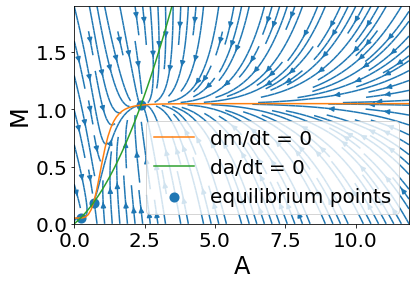

Equilibrium point: eigenvalues
[2.372 1.037]: [-0.29086813 -1.01763655]
[0.691 0.186]: [ 0.25318693 -1.50455764]
[0.227 0.051]: [-0.20557626 -1.01499021]


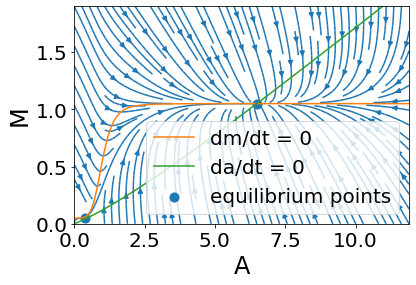

Equilibrium point: eigenvalues
[6.487 1.05 ]: [-0.22904733 -1.00010752]
[0.394 0.047]: [ 5.01382808e-04 -1.21690273e+00]


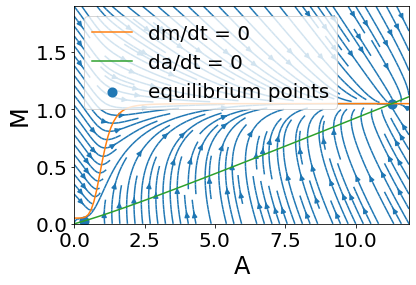

Equilibrium point: eigenvalues
[0.349 0.028]: [-6.70441607e-04 -1.20947853e+00]
[11.29  1.05]: [-0.21188307 -1.00000659]


In [4]:
%matplotlib inline

As = np.arange(0, 12, 0.1)
Ms = np.arange(0, 2, 0.1)

Ls = [1, 2, 3]

for L in Ls:
    system = lac_operon_system(L)
    system.plot_streamplot(As, Ms)
    system.identify_equilibrium_points(As, Ms)

In [5]:
def lac_operon_excercise_d(x0):

    system = lac_operon_system(1)

    t0 = np.linspace(0, 30, 301)
    sol0 = system.evolve_system(x0, t0)

    system.L = 2
    x1 = sol0[-1]
    t1 = np.linspace(30, 60, 301)
    sol1 = system.evolve_system(x1, t1)

    system.L = 3
    x2 = sol1[-1]
    t2 = np.linspace(60, 90, 301)
    sol2 = system.evolve_system(x2, t2)

    # Combine the solutions 
    t = np.concatenate((t0, t1, t2))
    sol = np.concatenate((sol0, sol1, sol2))

    ymin, ymax = np.min(sol), np.max(sol)

    plt.axvline(30, ls="--", color="k")
    plt.axvline(60, ls="--", color="k")
    plt.plot(t, sol[:, 0], label="A(t)")
    plt.plot(t, sol[:, 1], label="M(t)")
    plt.legend()
    plt.xlabel("t")
    plt.show()

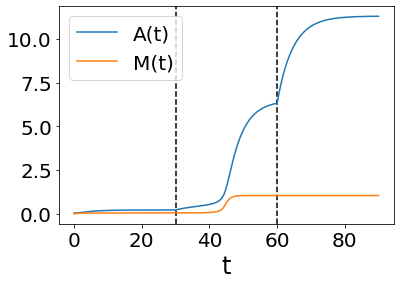

In [6]:
x0 = [0.05, 0]

%matplotlib inline
lac_operon_excercise_d(x0)